# Galaxy Classification, Anomaly Detection, Autoencoder & VAE (Keras)
This notebook uses the Galaxy10 DECaLS dataset (astronomical galaxy images) for:

1. Data loading & splitting, defining an anomaly class  
2. CNN classifier + ROC curves & confusion matrices  
3. Convolutional autoencoder for anomaly detection  
4. Variational autoencoder (VAE) + galaxy generation

Dataset: Galaxy10 DECaLS (HDF5).


In [ ]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import tensorflow as tf
import keras
from keras import layers, ops, Model, random, models

import numpy as np
import h5py
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay

## 1. Download the dataset, inspect classes, create anomaly split

Steps:
- Download `Galaxy10_DECals_64.h5`
- Load images and labels with `h5py`
- Inspect shape and class distribution
- Remove class 4 and store it as the anomaly dataset
- Split remaining (standard) data into train (50%), val (25%), test (25%)

In [ ]:
# Download Galaxy10 DECaLS (HDF5)
! rm ./Galaxy10_DECals_64.h5
! wget https://cernbox.cern.ch/remote.php/dav/public-files/RyWK8CBk2yqKR0b/Galaxy10_DECals_64.h5
data_path = "./Galaxy10_DECals_64.h5"

print("Downloaded to:", data_path)


In [ ]:
# Copy data onto drive s.t. dont need to download every time
from google.colab import drive
drive.mount('/content/drive')

import os
from pathlib import Path

# Pfade
drive_path = Path("/content/drive/MyDrive/Galaxy10_DECals_64.h5")
local_path = Path("./Galaxy10_DECals_64.h5")

#!cp "./Galaxy10_DECals_64.h5" "/content/drive/MyDrive/Galaxy10_DECals_64.h5"

# 1. case: data not on google drive
if not drive_path.exists():
    print("start download from cern...")
    !wget -O "{drive_path}" https://cernbox.cern.ch/remote.php/dav/public-files/RyWK8CBk2yqKR0b/Galaxy10_DECals_64.h5
    print("finished download from cern!")
else:
    print("dataset already on google drive")

# 2. case: data on google drive
if not local_path.exists():
    print("copy data from google drive into colab")
    !cp "{drive_path}" "{local_path}"
else:
    print("data already in colab")

# Endgültiger Pfad für den Rest deines Codes
data_path = "./Galaxy10_DECals_64.h5"
print(f"Data path: {data_path}")

In [ ]:
# Load images and labels using h5py
with h5py.File(data_path, "r") as f:
    images = np.array(f["images"])   # shape (17736, 256, 256, 3)
    labels = np.array(f["ans"])      # shape (17736,)

#  normalize pixels in [0,1]
images = images/255

print("Images shape:", images.shape)
print("Labels shape:", labels.shape, "dtype:", labels.dtype)

In [ ]:
# Class names from the Galaxy10 DECaLS documentation
class_names = {
    0: "Disturbed Galaxies",
    1: "Merging Galaxies",
    2: "Round Smooth Galaxies",
    3: "In-between Round Smooth Galaxies",
    4: "Cigar Shaped Smooth Galaxies",  # will be 'anomaly'
    5: "Barred Spiral Galaxies",
    6: "Unbarred Tight Spiral Galaxies",
    7: "Unbarred Loose Spiral Galaxies",
    8: "Edge-on Galaxies without Bulge",
    9: "Edge-on Galaxies with Bulge"
}

unique, counts = np.unique(labels, return_counts=True)
print("Class distribution:")
for u, c in zip(unique, counts):
    print(f"Class {u} ({class_names[u]}): {c}")

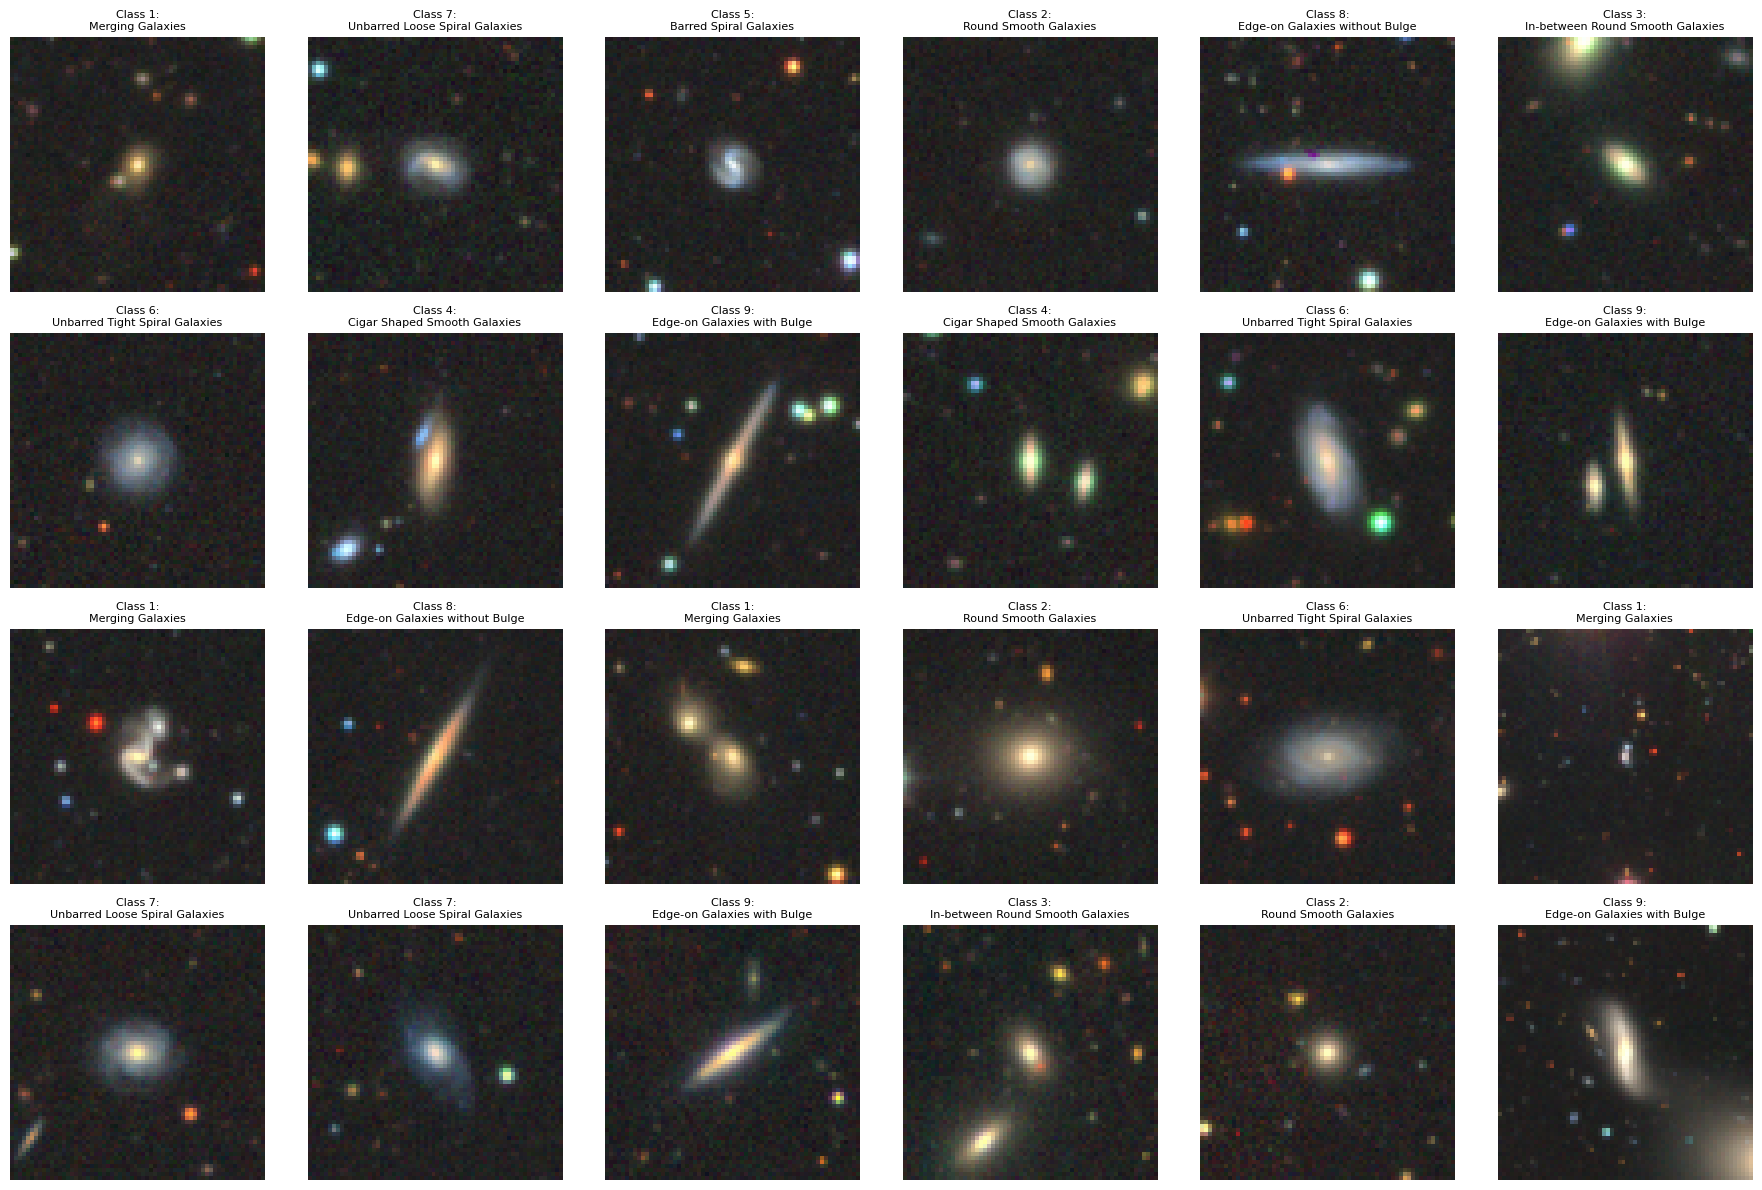

In [ ]:
# Show a grid of sample images from different classes
def show_examples(images, labels, class_names, n_rows=4, n_cols=6):
    plt.figure(figsize=(3*n_cols, 3*n_rows))
    indices = np.random.choice(len(images), size=n_rows*n_cols, replace=False)
    for i, idx in enumerate(indices):
        plt.subplot(n_rows, n_cols, i+1)
        plt.imshow(images[idx])
        plt.title(f"Class {labels[idx]}:\n{class_names[int(labels[idx])]}", fontsize=8)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

show_examples(images, labels, class_names)

In [ ]:
# Create anomaly dataset: all class 0 images
ANOMALY_CLASS = 0

anomaly_mask = (labels == ANOMALY_CLASS)
standard_mask = ~anomaly_mask

anom_images = images[anomaly_mask]
anom_labels = labels[anomaly_mask]  # all 0, but we keep them for bookkeeping

std_images = images[standard_mask]
std_labels_original = labels[standard_mask]

print("Standard images:", std_images.shape)
print("Anomaly images:", anom_images.shape)

In [ ]:
# For training, remap standard labels from {0,1,2,3,5,6,7,8,9} -> {0,...,8}
unique_std_classes = sorted(np.unique(std_labels_original))
print("Standard classes (original indices):", unique_std_classes)

# Create mapping dict
label_map = {original: new for new, original in enumerate(unique_std_classes)}
inv_label_map = {v: k for k, v in label_map.items()}

print("Label map (original -> new):", label_map)

std_labels = np.vectorize(label_map.get)(std_labels_original)
print("Remapped standard labels min/max:", std_labels.min(), std_labels.max())
n_classes = len(unique_std_classes)

In [ ]:
# Split standard data: 50% train, 25% val, 25% test

# First split: train (50%) and temp (50%)
X_train_std, X_temp_std, y_train_std, y_temp_std = train_test_split(
    std_images,
    std_labels,
    test_size=0.5,
    stratify=std_labels,
    random_state=42
)

# Second split: temp into val (25%) and test (25%) of full standard data
X_val_std, X_test_std, y_val_std, y_test_std = train_test_split(
    X_temp_std,
    y_temp_std,
    test_size=0.5,
    stratify=y_temp_std,
    random_state=42
)

print("Train standard:", X_train_std.shape, y_train_std.shape)
print("Val standard:  ", X_val_std.shape, y_val_std.shape)
print("Test standard: ", X_test_std.shape, y_test_std.shape)
del std_images, std_labels, X_temp_std, y_temp_std

In [ ]:
# Plot training history (accuracy and loss)
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Plot accuracy
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.set_title('Training and Validation Accuracy')
    ax1.legend()

    # Plot loss
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.set_title('Training and Validation Loss')
    ax2.legend()

    plt.show()

In [ ]:
# Plot ROC Curve
def plot_roc_curve(X_test, y_test, model):
    y_pred_proba = model.predict(X_test)

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(9):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve for each class
    plt.figure(figsize=(10, 8))
    for i in range(9):
        plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.6f})')

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

In [ ]:
import seaborn as sns

# Confusion Matrix
def plot_confusion_matrix(X_test, y_test, model):
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test, axis=1)

    conf_matrix = confusion_matrix(y_true, y_pred_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=list(range(9)), yticklabels=list(range(9)))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

## 2. CNN classifier + ROC curves + confusion matrices

Steps:
- Build a CNN classifier on the **standard** dataset (9 classes)
- Train on train set, validate on val set
- Plot training history (loss & accuracy)
- Compute ROC curves (one-vs-rest) on the standard test set
- Compute confusion matrix for standard test

In [ ]:
from keras.src.utils import to_categorical

# Convert labels into one-hot encoding
# (used as higher dimensional encoding st. each class is linear independent)
# (Modell learns to represent new datapoints near its label representation)

y_train_enc = to_categorical(y_train_std, 9)
y_val_enc = to_categorical(y_val_std, 9)
y_test_enc = to_categorical(y_test_std, 9)

print(y_train_enc[0])

[0. 0. 0. 0. 0. 0. 0. 0. 1.]


In [ ]:
# custom data augmentation layer
# used as a regularisation technique when training on rel. few data

data_augmentation = models.Sequential([
    layers.RandomRotation(0.12),
    #layers.RandomFlip("horizontal"),   # studies showed that rotation is not randomly distributed
    #layers.RandomFlip("vertical"),
    #layers.RandomZoom(0.05)    # Some Galaxies already zoomed in others tiny (could crop galaxies)
])

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

# add class weights
# some classes are less representated
# (only on train set s.t. no information about whole distribution is given to the model)

# calculation of weight
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_std),
    y=y_train_std
)

# weight dictionary
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

print(class_weight_dict)

{0: np.float64(0.9980822246194414), 1: np.float64(0.6998655236174147), 2: np.float64(0.9133486892618186), 3: np.float64(5.540252827677977), 4: np.float64(0.9061921863097181), 5: np.float64(1.0111718275652701), 6: np.float64(0.7041265009301539), 7: np.float64(1.299469413233458), 8: np.float64(0.9884852801519468)}


In [ ]:
# CNN Classifier
classifier_input = keras.Input(shape=(64, 64, 3))

# Data augmentation for some more regularization
x = data_augmentation(classifier_input)

# first layer
x = layers.Conv2D(16, (3, 3), padding="same")(x)
x = layers.BatchNormalization()(x)  # less dead neurons and vanaishing/exploding gradients
x = layers.Activation("relu")(x)
x = layers.MaxPooling2D((2, 2))(x)  # get some "stronger edges" (especially for small spiral structure)
                                    # get rid of noice
# second layer
x = layers.Conv2D(32, (3, 3), padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.MaxPooling2D((2, 2))(x)

# third layer
x = layers.Conv2D(64, (3, 3), padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)    # elu/LeakyRelu smoothed to much --> less exploration
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.25)(x)   # Get less Overfitting

# classifier layer
x = layers.Flatten()(x)
x = layers.Dense(24)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.Dropout(0.35)(x)   # Get less Overfitting
classifier_output = layers.Dense(9, activation="softmax")(x)  # Classification task gives last activation (prob vector)

classifier_model = keras.Model(classifier_input, classifier_output, name="classifier")

# compile the model
classifier_model.compile(optimizer="adamW",     # Added Adam with weight decay as regularization because of better generalization
                         loss="categorical_crossentropy",     # Used CCE because of categorical distribution of classes
                         metrics=["accuracy"]
                         )

# model summary
print(classifier_model.summary())

Model: "classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 24)             │        98,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24)             │            96 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 24)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 24)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │           225 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 122,681 (479.22 KB)

 Trainable params: 122,409 (478.16 KB)

 Non-trainable params: 272 (1.06 KB)

None


In [ ]:
# Early stopping, adaptive learning rate to avoid overfitting
callbacks = [
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss",   # LR scheduler to better converge when stuck on certain niveau
                                      factor=0.6,           # more stable convergence/optimization
                                      patience=4,
                                      min_lr=1e-6,
                                      verbose=1
                                      ),
    keras.callbacks.EarlyStopping(monitor="val_loss",   # reduce training time and less overfitting
                                  patience=15,    # st. no train stop before LR schedular stablelizes val_loss
                                  restore_best_weights=True,
                                  verbose=1
                                  ),
]

# Train model
classifier_fit = classifier_model.fit(X_train_std,
                                      y_train_enc,
                                      epochs=100,
                                      batch_size=16,
                                      validation_data=(X_val_std, y_val_enc),
                                      class_weight=class_weight_dict,
                                      callbacks=callbacks
                                      )

Epoch 1/100
521/521 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - accuracy: 0.2222 - loss: 2.0970 - val_accuracy: 0.3540 - val_loss: 1.6762 - learning_rate: 0.0010
Epoch 2/100
521/521 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.3477 - loss: 1.6930 - val_accuracy: 0.4342 - val_loss: 1.4475 - learning_rate: 0.0010
Epoch 3/100
521/521 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.4085 - loss: 1.4965 - val_accuracy: 0.4537 - val_loss: 1.4627 - learning_rate: 0.0010
Epoch 4/100
521/521 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.4197 - loss: 1.4635 - val_accuracy: 0.2882 - val_loss: 1.7103 - learning_rate: 0.0010
Epoch 5/100
521/521 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.4564 - loss: 1.3782 - val_accuracy: 0.4635 - val_loss: 1.2918 - learning_rate: 0.0010
Epoch 6/100
521/521 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.4922 - loss: 1.2991 - val_accuracy: 0.4287 - val_loss: 1.3466 - learning_rate: 0.0010
Epoch 7/100
521/521 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.4949 - 

In [ ]:
# Evaluate test set
test_loss, test_acc = classifier_model.evaluate(X_test_std, y_test_enc)
print(f"Test accuracy: {test_acc:.5f}")   # most of time between 74-80%

131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.7915 - loss: 0.5886
Test accuracy: 0.79923


In [ ]:
# accuracy is lower then expected if compared with ROC-Curve
# reasons: Class imbalance (argmax preferse bigger classes) and argmax vs threshhold

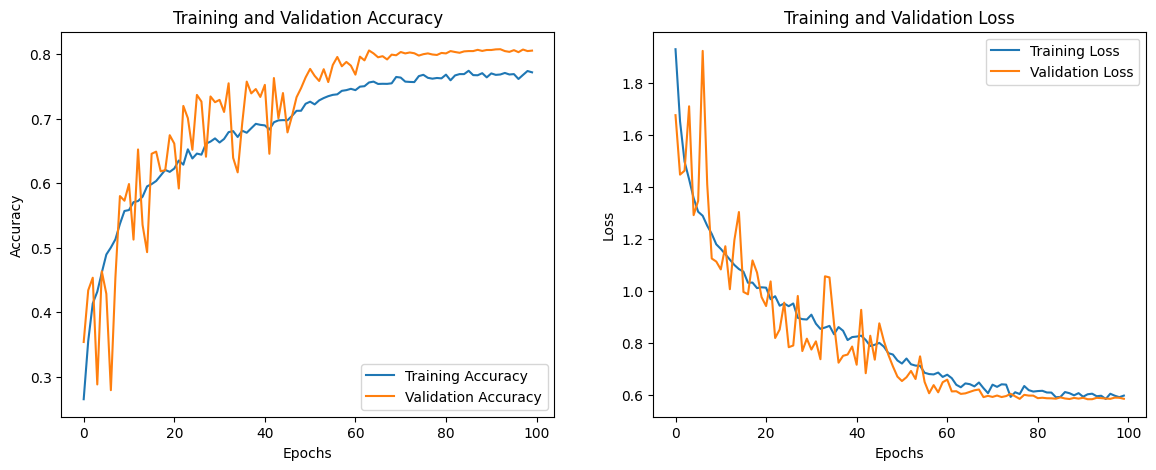

In [ ]:
plot_training_history(classifier_fit)

131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


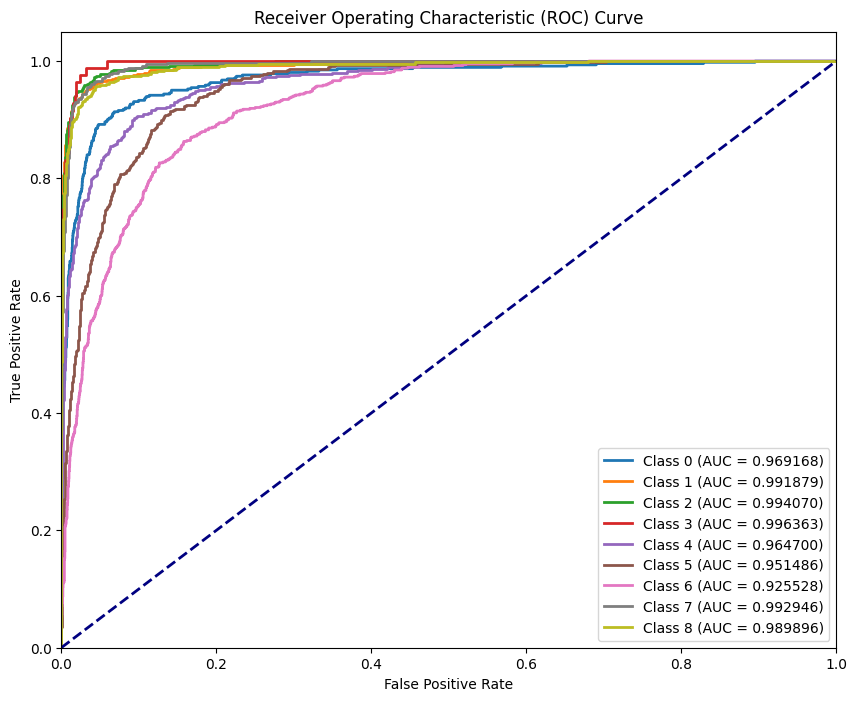

In [ ]:
plot_roc_curve(X_test_std, y_test_enc, classifier_model)

131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


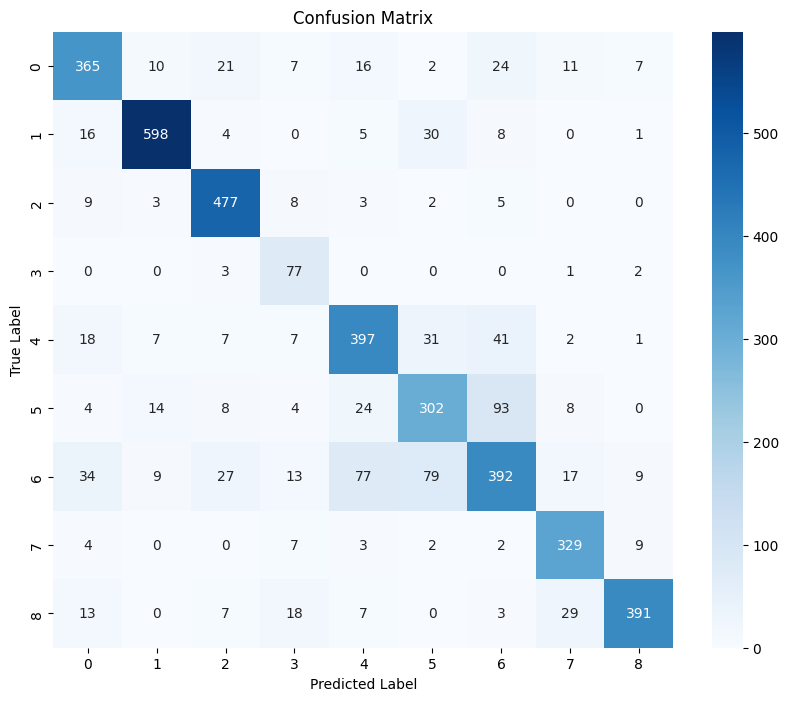

In [ ]:
plot_confusion_matrix(X_test_std, y_test_enc, classifier_model)

In [ ]:
# 0=Merging: missclassification most likely because of many different shapes
# 6=unbarred loose: missclassification most likely because of simalar color like barred (5) and not loose ones (4)
#                   sometimes shapes are very simillar (hard to distiguisch)
# 8=edge on buldge: sometimes buldge hard to see